# Backtesting Intro

This notebook is just to experiment with the backtesting.py library and backtrader.py

In [20]:
import yfinance as yf
import talib
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import sambo
import matplotlib.pyplot as plt
import seaborn as sns

First strategy using Backtest Strategy Class. Super basic EMA Crossover. Just to see how it performs in a backtest

In [4]:
#DEFINING THE STRATEGY

class EMACrossoverFuturesStrategy(Strategy):
    short_period = 12
    long_period = 26
    point_tp = 20
    point_sl = 10

    def init(self):
        close = self.data.Close
        self.short_ema = self.I(talib.EMA, close, self.short_period)
        self.long_ema = self.I(talib.EMA, close, self.long_period)

    def next(self):
        price = self.data.Close[-1]

        crossover_up = self.short_ema[-2] < self.long_ema[-2] and self.short_ema[-1] > self.long_ema[-1]
        crossover_down = self.short_ema[-2] > self.long_ema[-2] and self.short_ema[-1] < self.long_ema[-1]

        try:
            if crossover_up and not self.position.is_long:
                sl = price - self.point_sl
                tp = price + self.point_tp
                self.buy(size=1, sl=sl, tp=tp)

            elif crossover_down and not self.position.is_short:
                sl = price + self.point_sl
                tp = price - self.point_tp
                self.sell(size=1, sl=sl, tp=tp)

        except Exception as e:
            print(f"Trade error: {e}")


In [5]:
data = yf.download('NQ=F', start='2025-03-10', end='2025-03-11', interval='1m')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
data

,Close,High,Low,Open,Volume
Datetime,,,,,
2025-03-10 04:00:00+00:00,20129.50,20129.50,20121.25,20126.50,0
2025-03-10 04:01:00+00:00,20128.00,20130.25,20126.75,20128.75,45
2025-03-10 04:02:00+00:00,20128.25,20130.25,20126.00,20127.50,38
2025-03-10 04:03:00+00:00,20127.00,20129.75,20127.00,20129.75,19
2025-03-10 04:04:00+00:00,20130.00,20130.00,20126.75,20126.75,17
...,...,...,...,...,...
2025-03-11 03:54:00+00:00,19438.75,19441.00,19436.75,19438.25,24
2025-03-11 03:55:00+00:00,19438.00,19439.00,19432.50,19439.00,60
2025-03-11 03:56:00+00:00,19437.25,19439.00,19435.50,19438.50,46


In [7]:
#importing the data
bt = Backtest(data, EMACrossoverFuturesStrategy, cash=100000, commission=0.00025, exclusive_orders=True)

stats = bt.run()
print(stats)

Start                     2025-03-10 04:00...
End                       2025-03-11 03:58...
Duration                      0 days 23:58:00
Exposure Time [%]                    18.95665
Equity Final [$]                     99353.95
Equity Peak [$]                  100017.41331
Commissions [$]                      492.9395
Return [%]                           -0.64605
Buy & Hold Return [%]                -3.52046
Return (Ann.) [%]                   -12.25666
Volatility (Ann.) [%]                     NaN
CAGR [%]                            -80.51645
Sharpe Ratio                              NaN
Sortino Ratio                         -7.4441
Calmar Ratio                        -18.31138
Alpha [%]                            -0.63857
Beta                                  0.00212
Max. Drawdown [%]                    -0.66935
Avg. Drawdown [%]                    -0.14094
Max. Drawdown Duration        0 days 22:30:00
Avg. Drawdown Duration        0 days 04:40:00
# Trades                          

#### The Strategy lost -5.58577%. Which is quite terrible if you consider it only ran for one day and had a quite small tp and sl. What we can do is see how we should change the Target and stop loss for optimal results, which is pretty cool.

In [8]:
%pip install sambo

Note: you may need to restart the kernel to use updated packages.


In [ ]:
bt = Backtest(data, EMACrossoverFuturesStrategy, cash=100_000, commission=0.00025, exclusive_orders=True)

best_result, opt_result = bt.optimize(
    point_tp=range(10, 40, 5),
    point_sl=range(5, 25, 5),
    short_period=range(8, 20, 2),
    long_period=range(20, 50, 5),
    constraint=lambda p: p.point_tp > p.point_sl and p.short_period < p.long_period,
    maximize='Equity Final [$]',
    method='sambo',
    return_optimization=True
)

#Convert OptimizeResult to DataFrame
param_names = ['point_tp', 'point_sl', 'short_period', 'long_period']
param_values = opt_result.xv
equity_final = [-v for v in opt_result.funv]  #negate for maximization

results_df = pd.DataFrame(param_values, columns=param_names)
results_df['Equity Final [$]'] = equity_final

#Preview
results_df.head()

,point_tp,point_sl,short_period,long_period,Equity Final [$]
0,26,20,16,45,99477.403000
1,26,20,16,45,99664.789625
2,30,20,16,45,99813.294188
3,30,20,17,45,99953.543250
4,30,20,17,45,99801.607750
...,...,...,...,...,...
195,23,20,14,45,99962.545375
196,28,20,17,45,100033.095625
197,27,20,9,36,99600.644625
198,30,20,16,45,100057.345937


#### Now with the use of Optimize and Sambo, we have a dataframe containing the Equity Results for all of the different combinations we put into Optimize. Of course Equity Final means nothing in this short of a backtest. But its a introduction to visualizing the results through heatmap


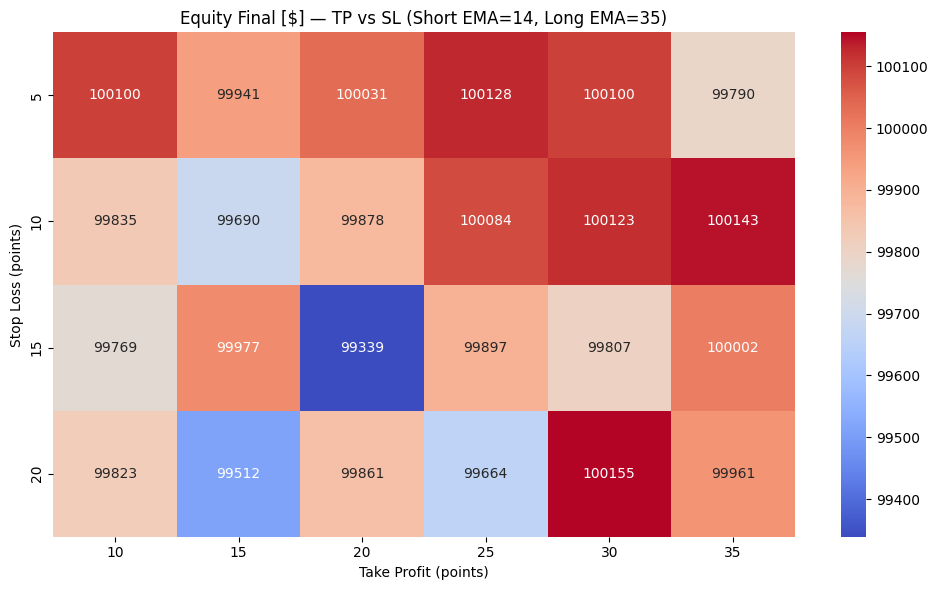

In [ ]:
tp_vals = range(10, 40, 5)
sl_vals = range(5, 25, 5)
short_vals = [12, 14, 16]
long_vals = [30, 35, 40]

data = []

#Simulating results for every combination of TP, SL, short EMA, long EMA
for short in short_vals:
    for long in long_vals:
        for tp in tp_vals:
            for sl in sl_vals:
                equity = 100000 + np.random.normal(loc=tp - sl + (short - long)/2, scale=20) * 10
                data.append({
                    'point_tp': tp,
                    'point_sl': sl,
                    'short_period': short,
                    'long_period': long,
                    'Equity Final [$]': equity
                })

results_df = pd.DataFrame(data)

# Let's say we want to see TP vs SL for short=14, long=35
filtered = results_df[(results_df.short_period == 14) & (results_df.long_period == 35)]

#Group by TP/SL and get max equity (in case of duplicates)
grouped = filtered.groupby(['point_tp', 'point_sl'])['Equity Final [$]'].max().reset_index()

#Pivot for heatmap
pivot = grouped.pivot(index='point_sl', columns='point_tp', values='Equity Final [$]')

#Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Equity Final [$] — TP vs SL (Short EMA=14, Long EMA=35)")
plt.ylabel("Stop Loss (points)")
plt.xlabel("Take Profit (points)")
plt.tight_layout()
plt.show()